In [1]:
import torch
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from utils import custom_dataset, analisando_saida_tensores
import random
from torch.functional import F

# Variáveis

In [3]:
IMG_SIZE = 150
N_GRIDS = 5

transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

inv_transformer = transforms.Compose([
    transforms.Normalize(mean=(-1., -1., -1), std=(2., 2., 2.)),
    transforms.ToPILImage()
])

def collate_function(batch):
    
    imgs_tensor, bbox_tensor, target_tensor = [], [], []
    
    for annotations, img_path in batch:
        for annotation in annotations:
            img_pil, p_obj, bbox_obj, bbox_cell, target = annotation
            imgs_tensor.append(transformer(img_pil))
            bbox_tensor.append(bbox_obj)
            target_tensor.append(target)
    
    imgs_tensor = torch.stack(imgs_tensor)
    bbox_tensor = torch.tensor(bbox_tensor, dtype=torch.float)
    target_tensor = torch.tensor(target_tensor, dtype=torch.long)

    return imgs_tensor, bbox_tensor, target_tensor

# Analisando dataset

In [4]:
dataset = custom_dataset('annotations.csv', IMG_SIZE=IMG_SIZE, N_GRIDS=N_GRIDS)
annotations, img_path = random.choice(dataset)
print (f'{len(dataset)=}')

len(dataset)=200


# Modelo

In [47]:
class custom_model(nn.Module):

    def __init__(self, input_batch, num_classes, IMG_SIZE, N_GRIDS, transformer_, inv_transformer_):
        super(custom_model, self).__init__()

        self.img_size = IMG_SIZE
        self.n_grids = N_GRIDS
        self.transformer = transformer_
        self.inv_transformer = inv_transformer_

        backbone = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, stride=1, padding=0),
            nn.LeakyReLU(negative_slope=0.1),

            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(num_features=64),
            nn.LeakyReLU(negative_slope=0.1),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(num_features=32),
            nn.LeakyReLU(negative_slope=0.1),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(num_features=16),

            nn.Flatten()
        )

        output = backbone(input_batch)
        n, input_channels = output.shape

        self.net = nn.Sequential(
            backbone,
            nn.Linear(in_features=input_channels, out_features=512, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=256, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=4+num_classes), # bbox[4] + número de classes
            nn.ReLU()
        )
    
    def forward(self, imgs_batch):
        return self.net(imgs_batch)
    
    def calculate_loss(self, output, bbox_batch, target_batch):
        
        bbox_pred = output[:,:4]
        target_pred = F.softmax(output[:,4:], dim=-1)

        loss_bbox = F.mse_loss(bbox_pred, bbox_batch)
        loss_target = F.cross_entropy(target_pred, target_batch)

        return (loss_bbox + loss_target)
    
    def detect(self, img_pil: Image, thresold=0.5):

        w_original, h_original = img_pil.size
        
        img_pil = img_pil.resize((self.img_size, self.img_size))

        cells_size = self.img_size / self.n_grids

        imgs, bboxes_cells = [], []
        for y in range(self.n_grids):
            for x in range(self.n_grids):
                x0b, y0b, x1b, y1b = x*cells_size, y*cells_size, (x+1)*cells_size, (y+1)*cells_size # valores absolutos
                bbox_celula = [x0b, y0b, x1b, y1b]
                img_croped = img_pil.crop(bbox_celula)
                imgs.append(self.transformer(img_croped))
                bboxes_cells.append(bbox_celula)
        
        imgs = torch.stack(imgs)

        self.net.eval()
        with torch.no_grad():
            output = self.net(imgs)
            deteccoes = output[:,:4] # detecção do objeto. no formato [xc, yc, w, h] ainda em percentual.
            target_pred = F.softmax(output[:,4:], dim=-1)
            prob_classes_cells, classes_cells = target_pred.max(1) # essa função max retorna uma tupla com os valores de fato que são maiores e na 
            # segunda parte da tupla seus respectivos índices, que são nossas classes.
        
        classes_cells = classes_cells.detach().cpu().numpy()
        deteccoes = deteccoes.detach().cpu().numpy()
        prob_classes_cells = prob_classes_cells.detach().cpu().numpy()

        # projetando as detecções de cada célula em valores absolutos. Lembrando que são referente à imagem redimensionada.
        deteccoes_final = []
        for k, (xc, yc, w, h) in enumerate(deteccoes): # para cada detecção (em percentual) das detecções

            classe = classes_cells[k]
            prob = prob_classes_cells[k]

            if (classe != 2 and prob >= thresold): # se não for a classe que corresponde ao último índice, ou seja, classe de imagem vazia.
                xc, yc, w, h = xc*cells_size, yc*cells_size, w*cells_size, h*cells_size  # formatando para valores absolutos da cells_size
                x0, y0, x1, y1 = bboxes_cells[k]
                
                # agora calculamos o xcfinal, ycfinal considerando valores relativos ao ponto (0,0) da imagem. 
                # Por isso foi considerado o x0+xc de cada célula para levar em consideração ao ponto de origem.
                # por fim foi relativizado ao tamanho da imagem original, não mais à célula. 
                xcf, ycf, wf, hf = (x0+xc)/self.img_size, (y0+yc)/self.img_size, w/self.img_size, h/self.img_size

                x0f, y0f, x1f, y1f = xcf-wf/2, ycf-hf/2, xcf+wf/2, ycf+hf/2 # calculando os pontos da box. ainda relativos
                x0f, y0f, x1f, y1f = x0f*w_original, y0f*h_original, x1f*w_original, y1f*h_original
                # trazendo os valores da bbox para os valores originais.

                deteccoes_final.append([[x0f, y0f, x1f, y1f], classe])  # detecção final para uma imagem que foi redimensionada

        return deteccoes_final


dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_function)
imgs_tensor, bbox_tensor, target_tensor = next(iter(dataloader))

print (f'{imgs_tensor.shape=}')

model = custom_model(imgs_tensor, 3, IMG_SIZE, N_GRIDS, transformer, inv_transformer)
output = model(imgs_tensor)
print (f'{output.shape=}')
loss = model.calculate_loss(output, bbox_tensor, target_tensor)
loss.backward()
print (loss)

imgs_tensor.shape=torch.Size([64, 3, 30, 30])
output.shape=torch.Size([64, 7])
tensor(1.3725, grad_fn=<AddBackward0>)


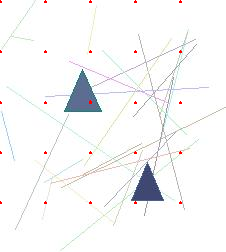

In [51]:
img_pil = Image.open('./imgs/img00001.jpg')
deteccoes = model.detect(img_pil, thresold=0.2)

draw = ImageDraw.Draw(img_pil)
for bbox, classe in deteccoes:
    cor = {0: 'red', 1: 'green'}
    draw.rectangle(bbox, fill=None, width=2, outline=cor[classe])

img_pil